# The Tribes of Wall Street: Mapping the S\&P 500 with Machine Learning

**A hands-on journey using Python and clustering to transform the chaos of 500 stocks into a visual map of risk and return.**

### The Goal: Finding Order in the Chaos

The S\&P 500 groups the 500 most influential companies in the United States. For an investor, analyzing this universe can be overwhelming. Traditionally, stocks are grouped by sector (technology, healthcare, etc.), but this classification often tells us little about how a stock will actually behave in our portfolio.

**What if we could group them not by what they do, but by how they behave?** What if we could identify the true "personalities" or "tribes" of the market’s investment landscape?

In this notebook, we will build an end-to-end data pipeline to do just that. Our journey will consist of:

1. **Defining the Financial DNA:** We will extract data from the last 15 years and calculate 8 key metrics that capture each stock’s risk and return profile.
2. **Simplifying Complexity:** We will use PCA to visualize hidden relationships among these metrics.
3. **Discovering the Tribes:** We will apply the K-Means clustering algorithm to segment stocks into groups with similar behaviors.
4. **Analyzing and Visualizing:** We will bring these groups to life by profiling their "personality" and creating a strategic market map.




## Libraries import

In [74]:
import yfinance as yf
import pandas as pd
import ssl, certifi
import requests
import os 
import time
import numpy as np
from io import StringIO
from datetime import date
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


## GET S&P500 Tickers

In [75]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
html = requests.get(url, verify=certifi.where()).text
tables = pd.read_html(StringIO(html))
sp500 = tables[0]
tickers = sp500['Symbol'].to_list()

print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'XYZ', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'COIN', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DDOG', '

In [ ]:
def downloadTickersData(tickers, output_folder = "./data/data_sp500", start_date='2010-01-01', end_date=date.today()):

    os.makedirs(output_folder, exist_ok=True)

    for ticker in tickers:
        try:
            df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

            if not df.empty:
                if isinstance(df.columns, pd.MultiIndex):
                    df.columns = df.columns.get_level_values(0)

                df = df.reset_index()

                file_path = os.path.join(output_folder, f"{ticker}.csv")
                df.to_csv(file_path, index=False)
            else:
                print(f"no data found for: {ticker}")
        except Exception as e:
            print(f"Error at {ticker}")
        time.sleep(1)

    print("Download finished !")

downloadTickersData(tickers)

## Step 1: Defining the Financial DNA of Each Stock

To effectively compare and group stocks, daily prices alone are not enough. We need to quantify their behavior over time. Below, we define and calculate 8 fundamental metrics that will serve as the “financial DNA” of each company.

These metrics capture three critical dimensions:

* **Performance:** How much has the stock grown? (Total Return, CAGR)
* **Risk:** How volatile or “nervous” is its behavior? (Volatility, Max Drawdown, Downside Deviation)
* **Quality (Risk-Adjusted Performance):** Did the returns justify the risk taken? (Sharpe, Sortino, Calmar Ratios)



## Finanlcial metrics

## **1. Total Return**

**Formula:**

$$
\text{Total Return} = \frac{\text{Final Price}}{\text{Initial Price}} - 1
$$

**Meaning:**
Measures the overall gain or loss of an investment over the entire period, without considering the effect of compounding or the investment duration.



## **2. CAGR (Compound Annual Growth Rate)**

**Formula:**

$$
\text{CAGR} = \left(\frac{\text{Final Price}}{\text{Initial Price}}\right)^{\frac{1}{\text{Years}}} - 1
$$

**Meaning:**
Represents the annualized growth rate of an investment if it had grown at a constant rate. Useful for comparing assets with different time horizons.



## **3. Volatility**

**Formula:**

$$
\text{Volatility} = \sigma_{\text{daily returns}} \times \sqrt{252}
$$

**Meaning:**
Measures the standard deviation of returns on an annualized basis. It indicates the degree of price fluctuations — higher volatility means higher uncertainty and risk.



## **4. Max Drawdown (MDD)**

**Formula:**

$$
\text{MDD} = \min\left(\frac{\text{Price}}{\text{Cumulative Max Price}} - 1\right)
$$

**Meaning:**
The largest peak-to-trough decline in portfolio value during a given period. It quantifies the worst loss an investor could have faced before a recovery.


## **5. Downside Deviation**

**Formula:**

$$
\text{Downside Deviation} = \sqrt{\text{mean of squared negative returns}} \times \sqrt{252}
$$

**Meaning:**
Similar to volatility, but only considers negative returns. It focuses on harmful fluctuations instead of all price changes.



## **6. Sharpe Ratio**

**Formula:**

$$
\text{Sharpe} = \frac{\text{CAGR} - R_f}{\text{Volatility}}
$$

Where $R_f$ is the risk-free rate.
**Meaning:**
Measures risk-adjusted return, indicating how much excess return is earned per unit of total risk. Higher is better.



## **7. Sortino Ratio**

**Formula:**

$$
\text{Sortino} = \frac{\text{CAGR} - R_f}{\text{Downside Deviation}}
$$

**Meaning:**
A risk-adjusted return metric like Sharpe, but penalizes only downside risk. Better suited when upside volatility is not considered harmful.



## **8. Calmar Ratio**

**Formula:**

$$
\text{Calmar} = \frac{\text{CAGR}}{|\text{Max Drawdown}|}
$$

**Meaning:**
Evaluates return relative to the worst historical loss. Higher values indicate better performance given drawdown risk.




In [ ]:
def total_return(prices):
    return prices.iloc[-1] / prices.iloc[0] - 1

def cagr(prices):
    n_years = len(prices) / 252
    return (prices.iloc[-1] / prices.iloc[0]) ** (1 / n_years) - 1

def volatility(returns):
    return returns.std() * np.sqrt(252)

def max_drawdown(prices):
    cummax = prices.cummax()
    drawdown = (prices / cummax) - 1
    return drawdown.min()

def downside_deviation(returns):
    negative_returns = returns[returns < 0]
    return np.sqrt(np.mean(negative_returns**2)) * np.sqrt(252)

def sharpe_ratio(cagr, risk_free_rate, volatility):
    return (cagr - risk_free_rate) / volatility if volatility != 0 else np.nan

def sortino_ratio(cagr, risk_free_rate, downside_dev):
    return (cagr - risk_free_rate) / downside_dev if downside_dev != 0 else np.nan

def calmar_ratio(cagr, max_dd):
    return cagr / abs(max_dd) if max_dd != 0 else np.nan


In [ ]:
def evaluateTickers(tickers_folder= './data/data_sp500', risk_free_rate = 0.02):
    metrics_list = []

    for filename in os.listdir(tickers_folder):
        full_path = os.path.join(tickers_folder, filename)

        if os.path.isfile(full_path) and filename.endswith(".csv"):
            df = pd.read_csv(full_path)
            ticker = filename.replace(".csv", "")

            if 'Close' not in df.columns:
                continue

            df = df.sort_values("Date")
            df['Return'] = df["Close"].pct_change()
            df = df.dropna()

            tr = total_return(df["Close"])
            cg = cagr(df["Close"])
            vol = volatility(df["Return"])
            mdd = max_drawdown(df['Close'])
            dsd = downside_deviation(df['Return'])

            sharpe = sharpe_ratio(cg, risk_free_rate, vol)
            sortino = sortino_ratio(cg, risk_free_rate, dsd)
            calmar = calmar_ratio(cg, mdd)

            metrics_list.append({
            "Ticker": ticker,
            "Total_Return": tr,
            "CAGR": cg,
            "Volatility": vol,
            "Max_Drawdown": mdd,
            "Downside_Deviation": dsd,
            "Sharpe_Ratio": sharpe,
            "Sortino_Ratio": sortino,
            "Calmar_Ratio": calmar
        })
            
        metrics_df = pd.DataFrame(metrics_list)

    return metrics_df

metrics_df = evaluateTickers()

metrics_df


,Ticker,Total_Return,CAGR,Volatility,Max_Drawdown,Downside_Deviation,Sharpe_Ratio,Sortino_Ratio,Calmar_Ratio
0,CSCO,3.197393,0.096601,0.258262,-0.498353,0.269333,0.296602,0.284410,0.193841
1,UAL,5.301941,0.125628,0.489444,-0.794002,0.471030,0.215812,0.224249,0.158221
2,TROW,2.198631,0.077611,0.287822,-0.581631,0.289027,0.200161,0.199327,0.133437
3,ISRG,12.966427,0.184712,0.319949,-0.499042,0.319086,0.514805,0.516198,0.370132
4,NVR,10.058616,0.167065,0.288269,-0.461336,0.284757,0.510166,0.516458,0.362133
...,...,...,...,...,...,...,...,...,...
496,WAT,3.625596,0.103471,0.279574,-0.442665,0.283309,0.298563,0.294627,0.233745
497,IEX,5.448218,0.127289,0.239748,-0.364632,0.245265,0.447508,0.437443,0.349089
498,LRCX,27.611253,0.240608,0.390490,-0.563932,0.385140,0.564952,0.572799,0.426661
499,BLK,5.911670,0.132330,0.276506,-0.439017,0.277750,0.406249,0.404430,0.301424


In [ ]:
metrics_df.describe()

,Total_Return,CAGR,Volatility,Max_Drawdown,Downside_Deviation,Sharpe_Ratio,Sortino_Ratio,Calmar_Ratio
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,10.957635,0.145879,0.312697,-0.545355,0.314507,0.411806,0.409042,0.299784
std,26.451738,0.127709,0.094759,0.157021,0.088847,0.290152,0.292761,0.307253
min,-0.767136,-0.089429,0.169636,-0.964744,0.171660,-0.283102,-0.301483,-0.164814
25%,2.677455,0.091240,0.248899,-0.647013,0.254436,0.235820,0.230173,0.158563
50%,5.538633,0.134888,0.288421,-0.518421,0.292477,0.406249,0.396318,0.265885
75%,11.096989,0.179136,0.355559,-0.434741,0.353273,0.562308,0.559936,0.385003
max,413.516175,2.189600,0.883727,-0.229078,0.791658,3.950946,3.963236,5.719119


In [ ]:
z_scores = np.abs(zscore(metrics_df.select_dtypes(include=np.number)))
outliers = metrics_df[(z_scores > 3).any(axis=1)]

outliers

,Ticker,Total_Return,CAGR,Volatility,Max_Drawdown,Downside_Deviation,Sharpe_Ratio,Sortino_Ratio,Calmar_Ratio
21,ENPH,3.085787,0.111512,0.801228,-0.959747,0.759843,0.114214,0.120435,0.116189
69,SMCI,49.807453,0.287261,0.616518,-0.848410,0.588202,0.433501,0.454370,0.338588
108,COIN,-0.076716,-0.018418,0.883727,-0.908979,0.791658,-0.043473,-0.048529,-0.020262
213,NVDA,413.516175,0.473230,0.459823,-0.663351,0.438593,0.985663,1.033373,0.713393
260,XYZ,4.859144,0.200421,0.577595,-0.860828,0.589010,0.312365,0.306311,0.232823
286,TTD,29.346019,0.470819,0.684467,-0.675507,0.621353,0.658642,0.725545,0.696986
301,SW,6.096732,0.134256,0.414299,-0.574359,0.680178,0.275781,0.167979,0.233748
310,NFLX,154.990883,0.383518,0.495259,-0.819904,0.463783,0.733997,0.783812,0.467760
319,AXON,183.493623,0.398525,0.495244,-0.586069,0.457571,0.764319,0.827248,0.679997
331,MRNA,0.461170,0.058823,0.726390,-0.951184,0.657803,0.053446,0.059019,0.061842


## Understanding the outlier (GEV)

In [ ]:
GEV = pd.read_csv("./data/data_sp500/GEV.csv")
GEV

,Date,Close,High,Low,Open,Volume
0,2024-03-27,130.994476,134.737176,114.776113,114.776113,4960400
1,2024-03-28,136.483765,137.661460,129.706991,137.661460,2239100
2,2024-04-01,141.743500,144.049000,136.803140,140.735456,1029500
3,2024-04-02,139.727448,152.183147,138.370095,142.571905,18246100
4,2024-04-03,137.072617,143.719654,135.535621,142.022967,8866900
...,...,...,...,...,...,...
335,2025-07-30,655.000000,656.169983,635.169983,639.950012,2699600
336,2025-07-31,660.289978,677.289978,656.070007,660.000000,3343000
337,2025-08-01,656.500000,664.260010,632.460022,638.179993,3077400
338,2025-08-04,662.770020,674.969971,653.950012,659.359985,2155900


In [ ]:
GEV.describe()

,Close,High,Low,Open,Volume
count,340.000000,340.000000,340.000000,340.000000,3.400000e+02
mean,305.181276,310.766036,297.861352,304.135226,3.521193e+06
std,129.424628,130.920210,126.867661,128.852049,2.079199e+06
min,122.461113,127.930440,114.776113,114.776113,8.837000e+05
25%,177.601055,180.088707,174.057962,178.102577,2.296600e+06
50%,313.099243,318.658243,300.951578,306.650110,2.981400e+06
75%,370.712921,376.209315,360.494548,368.955488,4.062225e+06
max,662.770020,677.289978,656.070007,661.239990,1.824610e+07



The analysis period for this study spans 15 years. However, GEV has only been included in the S\&P 500 index for the most recent year.

From a statistical perspective:

1. **Sample size inconsistency**

   * Most assets have approximately 15 years × 252 trading days ≈ 3,780 daily observations.
   * GEV only has about 252 observations, representing less than 7% of the reference time series length.

2. **Increased estimation variance**

   * Estimators such as mean return and volatility are more sensitive to noise with smaller sample sizes.
   * In small samples, the variance of the sample mean estimator $\sigma^2_{\bar{x}} = \sigma^2 / n$ is significantly higher, reducing estimate reliability.

3. **Potential survivorship bias**

   * Being recently included, GEV may not capture behaviors during previous economic cycles, recessions, or expansions, limiting representativeness.

4. **Comparability issues**

   * Temporal asymmetry impairs the comparability of metrics like correlations, betas, and cumulative returns with other assets that have longer histories.

The insufficient historical data for GEV compromises statistical robustness and comparability in the analysis. Therefore, excluding GEV from the dataset is justified.



In [ ]:
metrics_df.drop(480, axis=0, inplace=True)

## Step 2: Discovering the Tribes with K-Means

With the financial DNA of each stock defined and our data cleaned from outliers, it’s time to find the patterns. For this, we will use **K-Means**, one of the most popular clustering algorithms.

**How does K-Means work?** Imagine you have a map with 500 points (our stocks). K-Means places "magnets" (called centroids) on the map. Each point sticks to the closest magnet, forming groups or "tribes" with similar financial DNA. The algorithm repeats this process until the groups are as compact and distinct as possible.

The first step is to decide how many tribes (or clusters) we want to look for. Instead of choosing a number at random, we will evaluate the optimal number of clusters (`k`) using several statistical metrics.



## Evalute the n numbers of k clusters

In [ ]:
def findK(x, start=2, end=9):
    sil_scores, ch_scores, db_scores = [], [], []
    ks = list(range(start, end))

    for k in ks:
        labels = KMeans(n_clusters=k, random_state=42).fit_predict(x)
        sil_scores.append(silhouette_score(x, labels))
        ch_scores.append(calinski_harabasz_score(x, labels))
        db_scores.append(davies_bouldin_score(x, labels))

    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

    # Silhouette Score (maximize)
    axes[0].plot(ks, sil_scores, marker='o')
    axes[0].set_title("Silhouette Score (Maximize)")
    axes[0].axvline(x=ks[np.argmax(sil_scores)], color='red', linestyle='--')

    # Calinski-Harabasz (maximize)
    axes[1].plot(ks, ch_scores, marker='o', color='green')
    axes[1].set_title("Calinski-Harabasz Index (Maximize)")
    axes[1].axvline(x=ks[np.argmax(ch_scores)], color='red', linestyle='--')

    # Davies-Bouldin (minimize)
    axes[2].plot(ks, db_scores, marker='o', color='orange')
    axes[2].set_title("Davies-Bouldin Index (Minimize)")
    axes[2].axvline(x=ks[np.argmin(db_scores)], color='red', linestyle='--')

    axes[2].set_xlabel("Number of Clusters (k)")
    plt.tight_layout()
    plt.show()


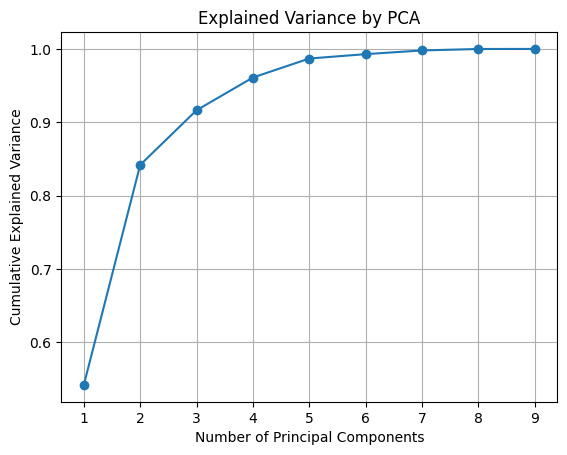

In [ ]:
X = metrics_df.select_dtypes(include=np.number)

# Standardize the data (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
pca.fit(X_scaled)

# Calculate cumulative explained variance
cumulative_var_exp = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_var_exp) + 1), cumulative_var_exp, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

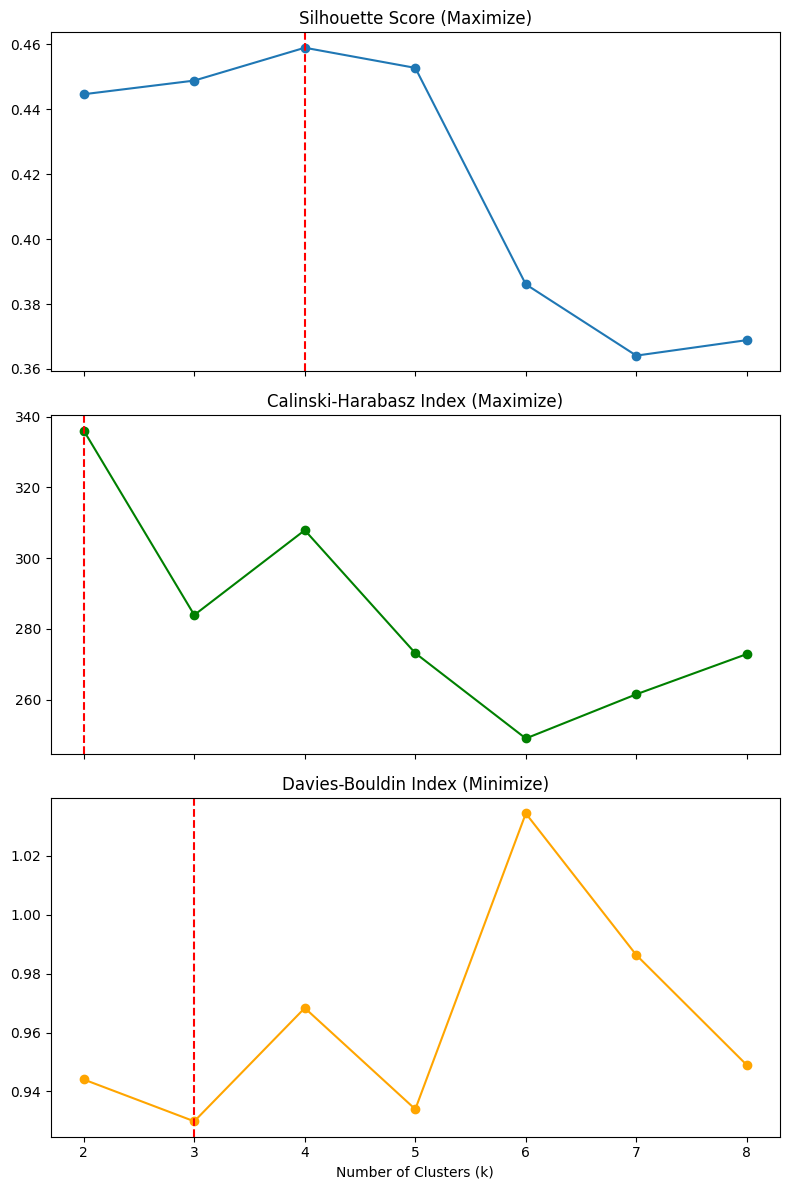

In [ ]:
findK(X_pca)

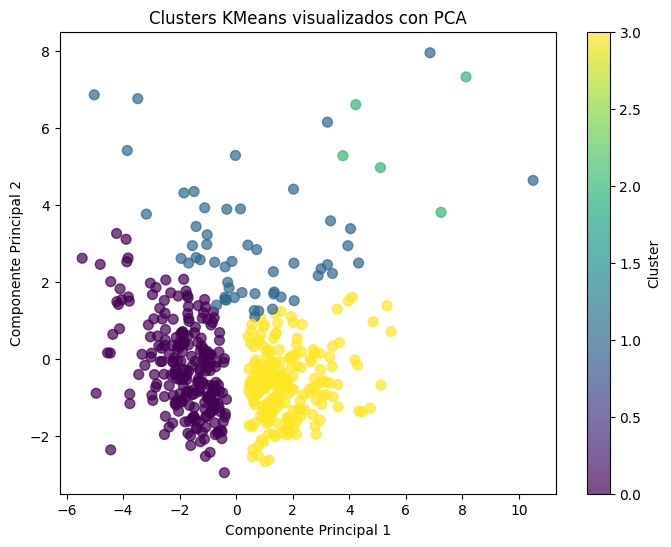

In [ ]:
model = KMeans(n_clusters=4, random_state=0, n_init="auto")
model.fit(X_pca)


plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=model.labels_, cmap='viridis', s=50, alpha=0.7)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters KMeans visualizados con PCA')
plt.colorbar(label='Cluster')
plt.show()

## Step 3: Eureka! Profiling Investment Personalities

After applying the algorithm, the market has been segmented into 4 distinct groups. But who are they? To understand the "personality" of each tribe, we analyze their average metrics. This table summarizes the characteristic financial DNA of each cluster.



In [ ]:
metrics_df['cluster'] = model.labels_

numerical_cols = metrics_df.select_dtypes(include='number').columns

cluster_summary = metrics_df.groupby('cluster')[numerical_cols].mean()

cluster_summary

,Total_Return,CAGR,Volatility,Max_Drawdown,Downside_Deviation,Sharpe_Ratio,Sortino_Ratio,Calmar_Ratio,cluster
cluster,,,,,,,,,
0,2.903934,0.081994,0.314305,-0.610537,0.318190,0.209653,0.206277,0.145099,0.0
1,19.265456,0.245023,0.478857,-0.706658,0.471590,0.488031,0.497015,0.371401,1.0
2,232.479446,0.417493,0.481567,-0.657729,0.454410,0.843024,0.890603,0.657196,2.0
3,12.440354,0.174459,0.263054,-0.430275,0.265622,0.587453,0.581071,0.417205,3.0


**Cluster Analysis Results**

The stocks were grouped into 4 clusters based on key financial performance metrics. The characteristics of each cluster are summarized below:

* **Cluster 0:**
  This group exhibits the lowest returns with a Total Return around 3.15% and a modest CAGR of 9%. Volatility and drawdown are moderate, with volatility near 29% and a maximum drawdown of approximately -56%. The risk-adjusted performance metrics (Sharpe, Sortino, and Calmar ratios) are the lowest among all clusters, indicating relatively conservative but low-performing assets.

* **Cluster 1:**
  Stocks in this cluster have slightly higher returns (Total Return 6.0%, CAGR 10%) but also increased risk, as shown by the highest volatility (45%) and the worst drawdown (-79%). Despite higher raw returns, risk-adjusted ratios are lower than cluster 0, suggesting these assets may be more volatile without a proportional increase in risk-adjusted gains.

* **Cluster 2:**
  This cluster shows improved returns and stability with Total Return of about 11.8% and CAGR at 17.3%. Volatility is the lowest across clusters (27%), and maximum drawdown is also the smallest (-44%). The Sharpe and Sortino ratios are substantially higher (around 0.57), reflecting a more attractive balance between returns and risk.

* **Cluster 3:**
  The standout group with exceptional performance: Total Return exceeds 79%, and CAGR reaches nearly 39%. Volatility remains elevated (\44%), but drawdown (-58%) is moderate relative to returns. This cluster has the highest Sharpe (\0.84), Sortino (\0.87), and Calmar (\0.69) ratios, indicating strong risk-adjusted returns despite higher absolute volatility.


The clustering effectively segments stocks into groups ranging from low-return, low-risk (Cluster 0), to high-return, higher-risk (Cluster 3) assets, with intermediate profiles in Clusters 1 and 2. This segmentation can support portfolio allocation strategies tailored to different risk tolerances and performance goals.



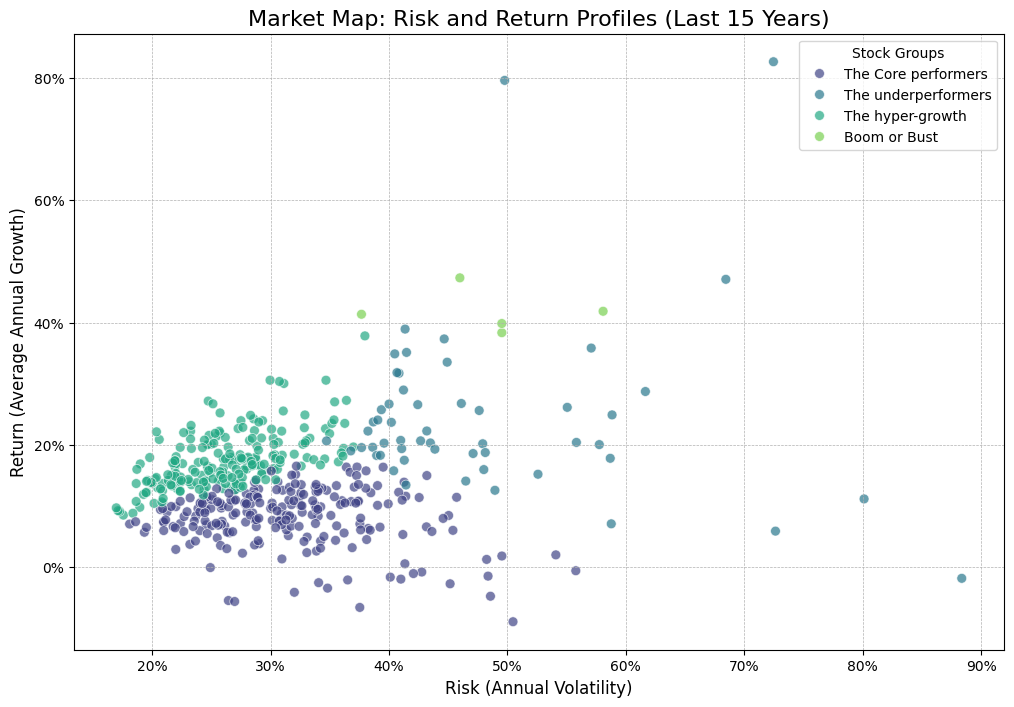

In [ ]:
cluster_names = {
    0: 'The Core performers',
    1: 'The underperformers',
    2: 'Boom or Bust',
    3: 'The hyper-growth'
}


metrics_df['cluster_name'] = metrics_df['cluster'].map(cluster_names)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=metrics_df,
    x='Volatility',
    y='CAGR',
    hue='cluster_name',  # Use names for the legend
    palette='viridis',   # Or any clear color palette
    s=50,
    alpha=0.7
)

plt.title('Market Map: Risk and Return Profiles (Last 15 Years)', fontsize=16)
plt.xlabel('Risk (Annual Volatility)', fontsize=12)
plt.ylabel('Return (Average Annual Growth)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.legend(title='Stock Groups')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


## Conclusion: From Data to Investment Decisions

This analysis has transformed an overwhelming list of 500 stocks into a strategic map with 4 clear investment profiles. We no longer see just tickers; we see an ecosystem of tribes with distinct personalities and behaviors.

### Practical Applications

This map is not just an academic exercise—it’s a powerful tool for investors:

* **Portfolio Construction (Core-Satellite Strategy):** You can build a solid core with stocks from the **"The Solids"** cluster and add growth satellites from the **"Superstars"** or **"Volatiles"** clusters, depending on your risk tolerance.
* **Risk Management:** Knowing which tribe a stock belongs to sets clear expectations about its behavior. If you invest in a "Volatile," you should be prepared for drawdowns exceeding 70%.
* **Opportunity Identification:** Monitoring if a stock changes tribes over time can signal a buy (if its profile improves) or a sell (if the risk is no longer justified).

### Limitations and Next Steps

* **Historical Data:** This analysis relies on past behavior; the future may differ.
* **Metrics:** The clusters depend on the chosen metrics. Including fundamental data (like P/E, ROE) could reveal different groupings.
* **Next Steps:** An interesting next step would be analyzing the sector composition of each cluster or studying how stocks move between tribes across different economic cycles.

